In [5]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns
from utilities.bt_analysis import get_metrics, backtest_analysis
from utilities.plot_analysis import plot_equity_vs_asset, plot_futur_simulations, plot_bar_by_month
import nest_asyncio
nest_asyncio.apply()

In [6]:
class Strategy():
    def __init__(
        self,
        df_list,
        oldest_pair,
        type=["long"],
        params={},
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

        
    def populate_indicators(self):
        for pair in self.df_list:
            params = self.params[pair]
            df = self.df_list[pair]
            df.drop(
                columns=df.columns.difference(['open','high','low','close','volume']), 
                inplace=True
            )
            
            # -- Populate indicators --    
            df['fast_ma'] = ta.trend.sma_indicator(close=df["close"], window=params["fast_ma"])
            df['slow_ma'] = ta.trend.sma_indicator(close=df["close"], window=params["slow_ma"])
            df['mrat'] = df['fast_ma'] / df['slow_ma']
            df['signal'] = ta.trend.sma_indicator(close=df['mrat'], window=params["signal"])
        
            self.df_list[pair] = df
  
        return self.df_list[self.oldest_pair]
    
    def populate_buy_sell(self): 
        full_list = []
        for pair, df in self.df_list.items():
            params = self.params[pair]
            df['pair'] = pair
            full_list.append(df)

        df_full = pd.concat(full_list)
        df_full = df_full.sort_index()
        self.open_long_obj = df_full[df_full['mrat'] >= df_full['signal']].groupby('date')['pair'].apply(list).to_dict() if self.use_long else {}
        self.close_long_obj = df_full[df_full['mrat'] < df_full['signal']].groupby('date')['pair'].apply(list).to_dict() if self.use_long else {}
        self.open_short_obj = df_full[df_full['mrat'] < df_full['signal']].groupby('date')['pair'].apply(list).to_dict() if self.use_short else {}
        self.close_short_obj = df_full[df_full['mrat'] >= df_full['signal']].groupby('date')['pair'].apply(list).to_dict() if self.use_short else {}
        
        return self.df_list[self.oldest_pair]    
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        params = self.params
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        long_exposition = 0
        short_exposition = 0
        maker_fee = 0.0002
        taker_fee = 0.0006
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}
        
        for index, ini_row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pair in current_positions:
                    row = self.df_list[pair].loc[index]
                    position = current_positions[pair]
                    if position['side'] == "LONG":
                        close_price = row['open']
                        trade_result = (close_price - position['price']) / position['price']
                        close_size = position['size'] + position['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position['size'] - fee
                    elif position['side'] == "SHORT":
                        close_price = row['open']
                        trade_result = (position['price'] - close_price) / position['price']
                        close_size = position['size'] + position['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":ini_row['open'],
                    "long_exposition":0,
                    "short_exposition":0,
                    "risk":0,
                })
            previous_day = current_day 
            
            
            close_long_row = self.close_long_obj[index] if index in self.close_long_obj else []
            close_short_row = self.close_short_obj[index] if index in self.close_short_obj else []
            if len(current_positions) > 0:
                # -- Close LONG --
                long_position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "LONG"}).intersection(set(close_long_row))
                for pair in long_position_to_close:
                    row = self.df_list[pair].loc[index]
                    position = current_positions[pair]
                    close_price = row['close']
                    trade_result = (close_price - position['price']) / position['price']
                    close_size = position['size'] + position['size'] * trade_result
                    fee = close_size * maker_fee
                    wallet += close_size - position['size'] - fee
                    trades.append({
                        "pair": pair,
                        "open_date": position['date'],
                        "close_date": index,
                        "position": position['side'],
                        "open_reason": position['reason'],
                        "close_reason": "Market",
                        "open_price": position['price'],
                        "close_price": close_price,
                        "open_fee": position['fee'],
                        "close_fee": fee,
                        "open_trade_size":position['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                    })
                    del current_positions[pair]
                    
                # -- Close SHORT --
                short_position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "SHORT"}).intersection(set(close_short_row))
                for pair in short_position_to_close:
                    row = self.df_list[pair].loc[index]
                    position = current_positions[pair]
                    close_price = row['close']
                    trade_result = (position['price'] - close_price) / position['price']
                    close_size = position['size'] + position['size'] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - position['size'] - fee
                    trades.append({
                        "pair": pair,
                        "open_date": position['date'],
                        "close_date": index,
                        "position": position['side'],
                        "open_reason": position['reason'],
                        "close_reason": "Market",
                        "open_price": position['price'],
                        "close_price": close_price,
                        "open_fee": position['fee'],
                        "close_fee": fee,
                        "open_trade_size":position['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                    })
                    del current_positions[pair]
                    
            # -- Check for opening position --
            # -- Open LONG --
            open_long_row = self.open_long_obj[index] if index in self.open_long_obj else []
            for pair in open_long_row:
                if pair not in current_positions:
                    row = self.df_list[pair].loc[index]
                    open_price = row["close"]
                    pos_size = (params[pair]["size"] * wallet * leverage)
                    fee = pos_size * taker_fee
                    pos_size -= fee
                    wallet -= fee
                    current_positions[pair] = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                    long_exposition += 0
            # -- Open SHORT --
            open_short_row = self.open_short_obj[index] if index in self.open_short_obj else []
            for pair in open_short_row:
                if pair not in current_positions:
                    row = self.df_list[pair].loc[index]
                    open_price = row["close"]
                    pos_size = (params[pair]["size"] * wallet * leverage)
                    fee = pos_size * taker_fee
                    pos_size -= fee
                    wallet -= fee
                    current_positions[pair] = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT",
                    }
                    short_exposition += 0              

        if len(trades) == 0:
            raise ValueError('No trades have been made')
                  
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }      

In [7]:
params = {
    "BTC/USDT":{
        "fast_ma": 10,
        "slow_ma": 100,
        "signal": 20,
        "size": 0.33,
    },
    "ETH/USDT":{
        "fast_ma": 10,
        "slow_ma": 100,
        "signal": 20,
        "size": 0.33,
    },
    "LINK/USDT":{
        "fast_ma": 10,
        "slow_ma": 100,
        "signal": 20,
        "size": 0.33,
    },
}

pair_list = list(params.keys())
exchange_name = "binance"
tf = '4h'
oldest_pair = "BTC/USDT"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df_list = {}
for pair in pair_list:
    df = exchange.load_data(pair, tf)
    df_list[pair] = df.loc[:]

print("Data load 100%")
df_list[oldest_pair]

Data load 100%


,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882
2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001
2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716
2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913
...,...,...,...,...,...
2024-02-15 12:00:00,52330.00,52816.62,51721.31,51948.23,13915.591540
2024-02-15 16:00:00,51948.24,52380.00,51725.00,52002.01,9258.377940
2024-02-15 20:00:00,52002.01,52011.10,51314.00,51880.00,8216.997050


In [8]:
strat = Strategy(
    df_list=df_list,
    oldest_pair=oldest_pair,
    type=["long"],
    params=params,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)

df_trades, df_days = backtest_analysis(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=True,
    pair_info=True,
    indepedant_trade=True
)

Period: [2017-09-06 00:00:00] -> [2024-02-16 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 91289.56 $
Performance: 9028.96 %
Sharpe Ratio: 1.77 | Sortino Ratio: 2.52 | Calmar Ratio: 1.76
Worst Drawdown T|D: -41.19% | -45.45%
Buy and hold performance: 1088.14 %
Performance vs buy and hold: 668.34 %
Total trades on the period: 816
Average Profit: 1.98 %
Global Win rate: 42.28 %

--- Trades Information ---
Mean Trades per day: 0.35
Mean Trades Duration: 4 days 00:53:31.764705882
Best trades: +74.51 % the 2019-06-25 04:00:00 -> 2019-07-01 20:00:00 (LINK/USDT)
Worst trades: -15.43 % the 2019-02-24 04:00:00 -> 2019-02-24 16:00:00 (ETH/USDT)
Total Good trades on the period: 345
Total Bad trades on the period: 471
Average Good Trades result: 9.91 %
Average Bad Trades result: -3.84 %
Mean Good Trades Duration: 5 days 20:37:33.913043478
Mean Bad Trades Duration: 2 days 16:51:27.898089171

--- Days Informations ---
Total: 2355 days recorded
Winning days: 902 days (

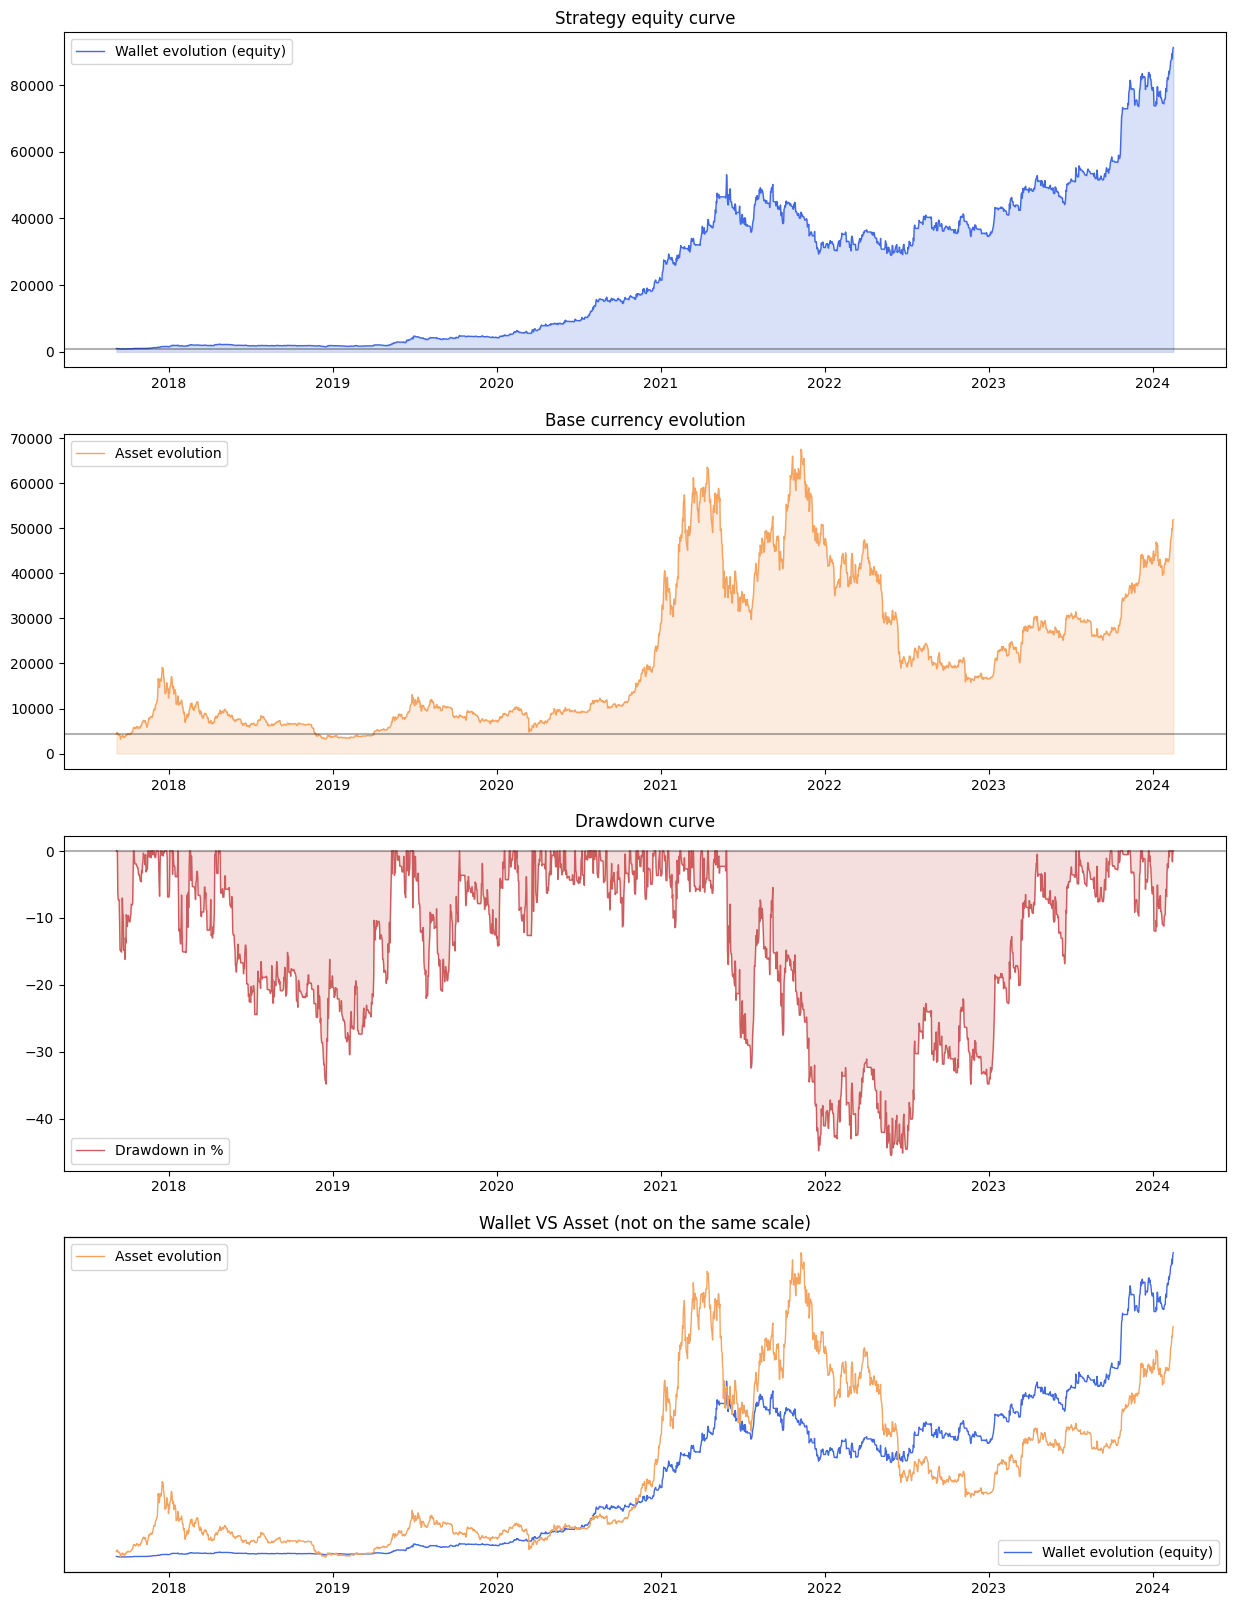

In [9]:
plot_equity_vs_asset(df_days=df_days.loc[:])

----- 2017 Cumulative Performances: 55.05% -----


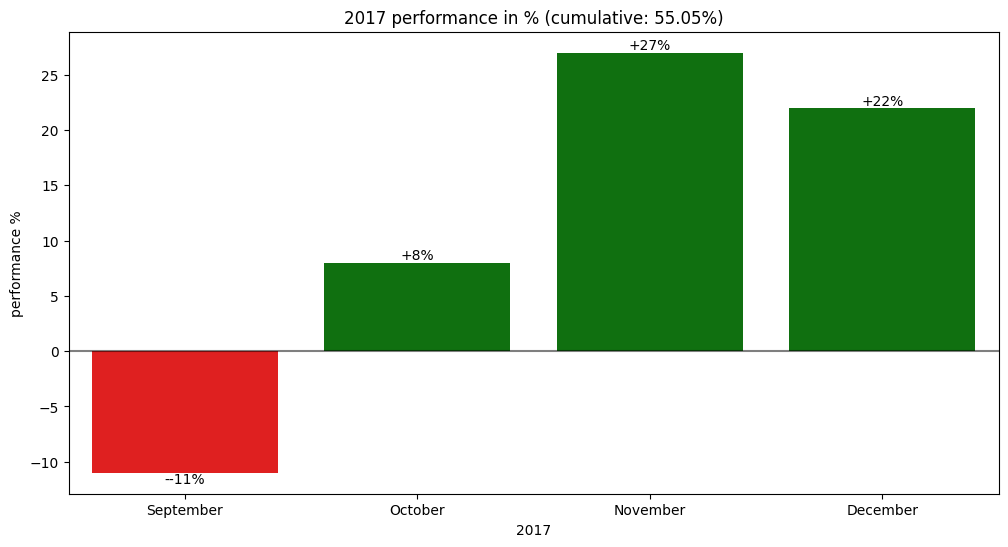

----- 2018 Cumulative Performances: 22.45% -----


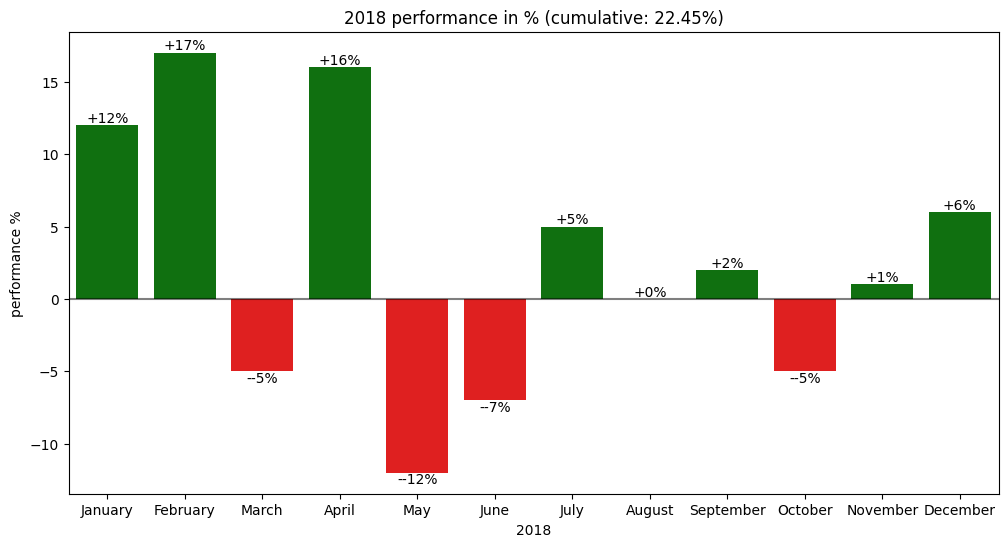

----- 2019 Cumulative Performances: 132.02% -----


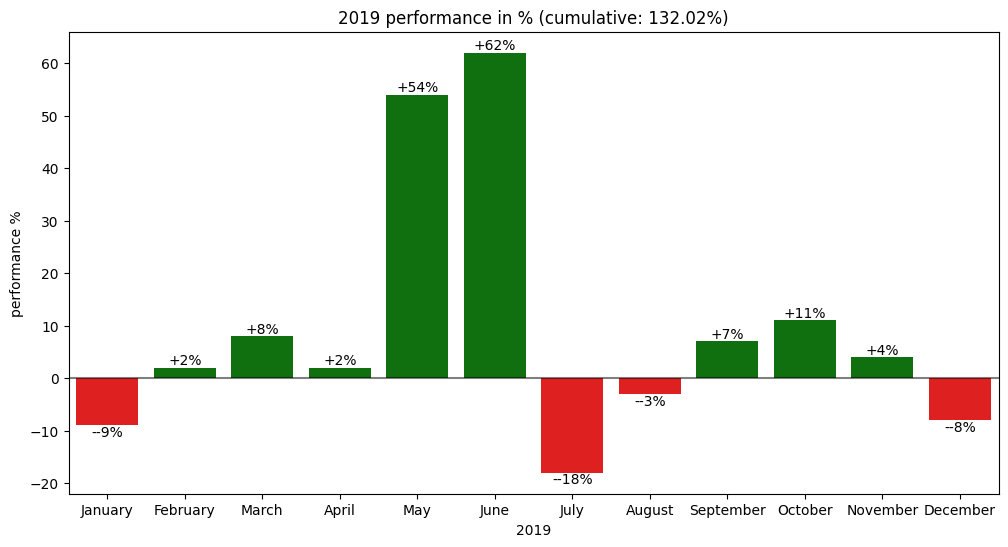

----- 2020 Cumulative Performances: 406.31% -----


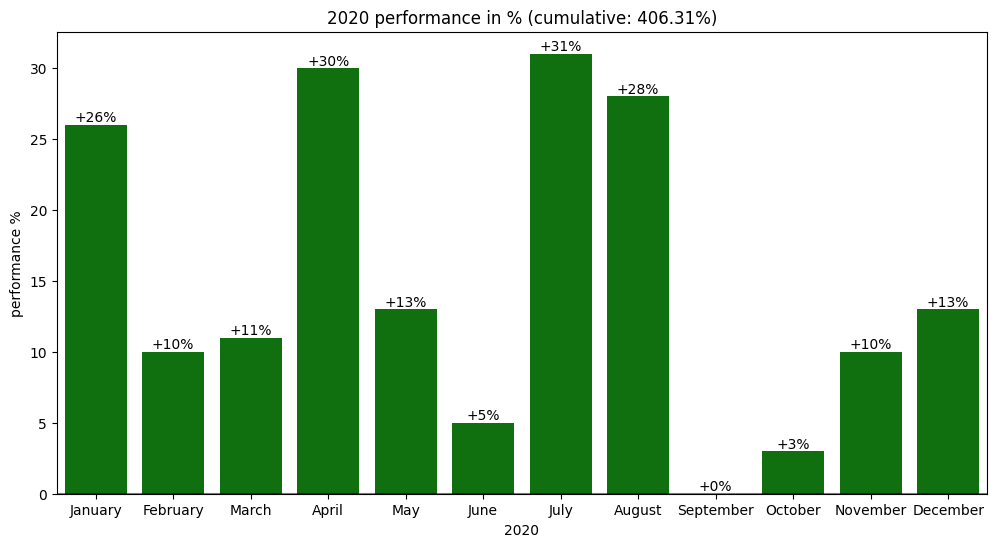

----- 2021 Cumulative Performances: 45.93% -----


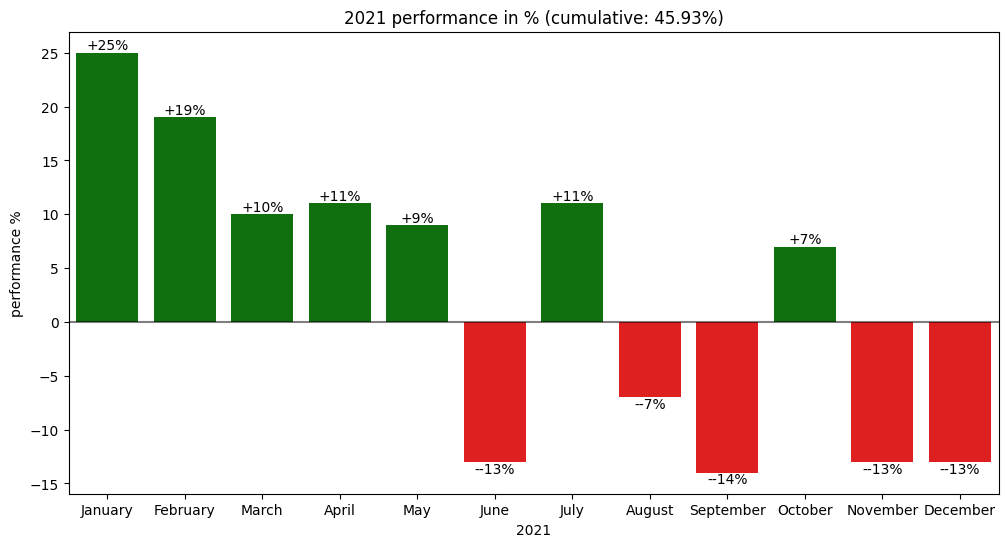

----- 2022 Cumulative Performances: 10.73% -----


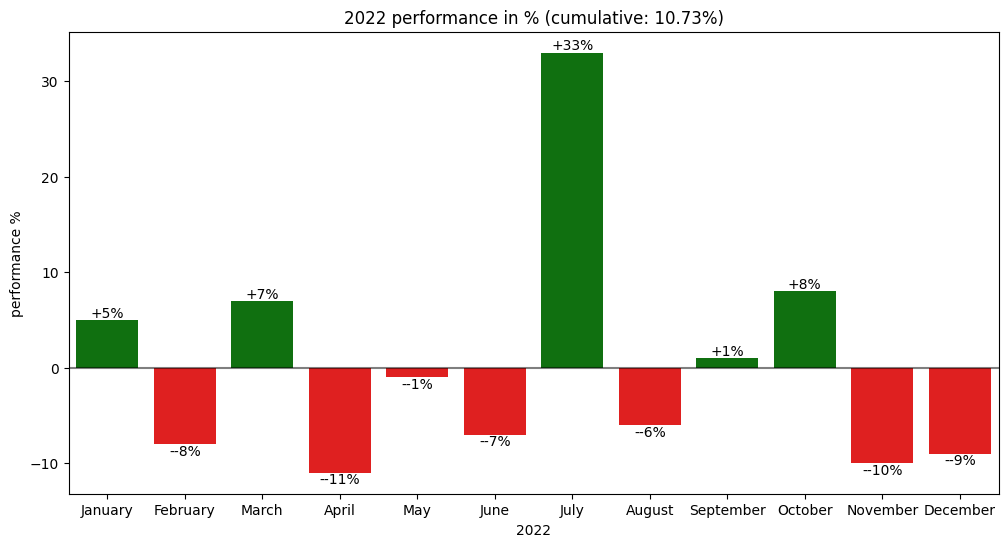

----- 2023 Cumulative Performances: 126.58% -----


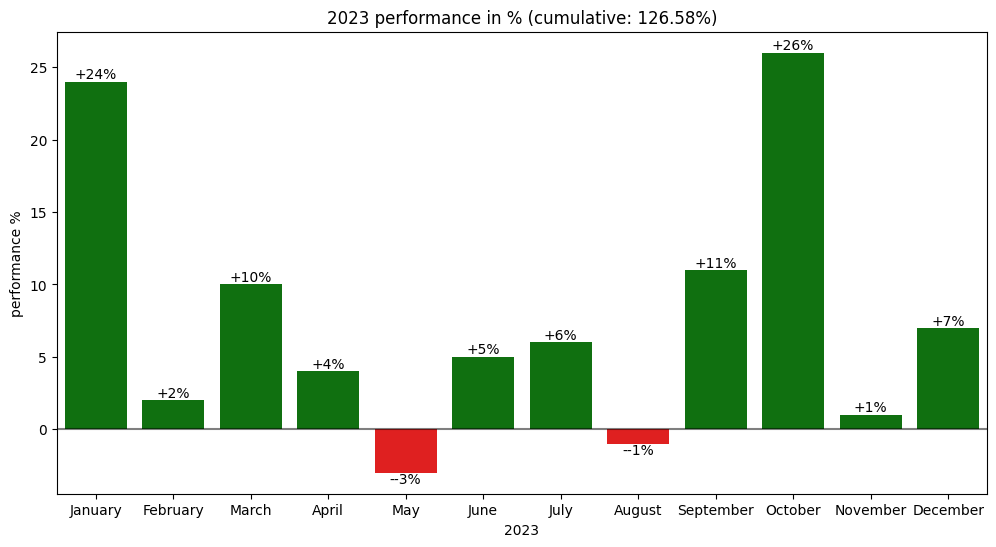

----- 2024 Cumulative Performances: 16.35% -----


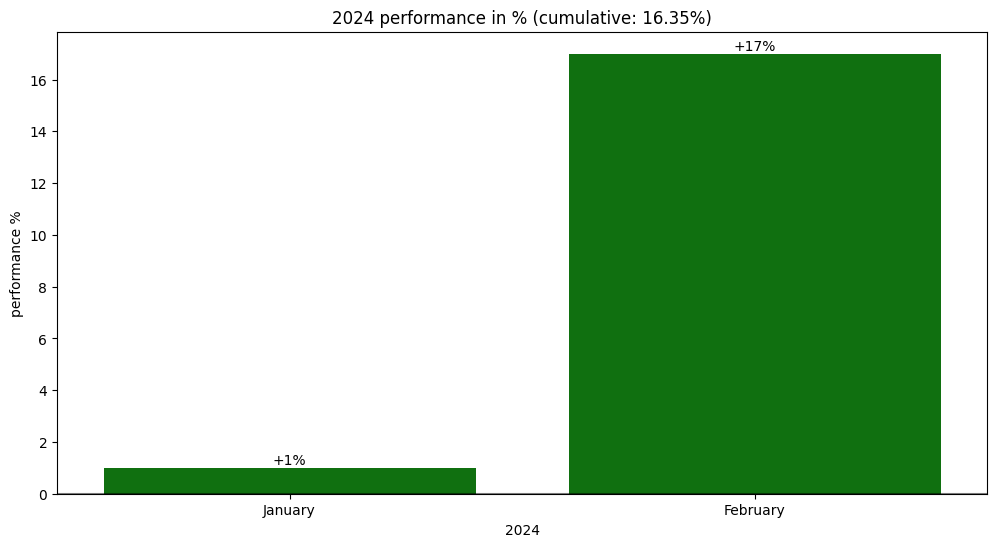

In [10]:
plot_bar_by_month(df_days=df_days)

In [11]:
df_trades.sort_values(by=["trade_result_pct"])

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2019-02-24 04:00:00,ETH/USDT,2019-02-24 04:00:00,2019-02-24 16:00:00,LONG,Market,Market,164.1700,138.9400,0.368392,0.103863,613.618816,519.316551,1765.424457,-94.670657,-0.154283,-0.056663,0 days 12:00:00,2309.893156,544.468698,0.235712
2017-09-12 04:00:00,ETH/USDT,2017-09-12 04:00:00,2017-09-13 12:00:00,LONG,Market,Market,314.1500,266.9300,0.184243,0.052152,306.887661,260.759266,855.189768,-46.312638,-0.150911,-0.057255,1 days 08:00:00,957.527213,102.337445,0.106877
2021-09-05 16:00:00,LINK/USDT,2021-09-05 16:00:00,2021-09-08 00:00:00,LONG,Market,Market,32.8400,28.0300,9.694174,2.756442,16147.263089,13782.210243,45036.939207,-2374.747020,-0.147068,-0.055664,2 days 08:00:00,48999.313862,3962.374655,0.080866
2019-07-13 16:00:00,LINK/USDT,2019-07-13 16:00:00,2019-07-14 20:00:00,LONG,Market,Market,3.2289,2.7856,0.859745,0.247088,1432.047782,1235.440026,4144.429432,-197.467500,-0.137892,-0.050030,1 days 04:00:00,4675.846637,531.417205,0.113652
2021-08-16 08:00:00,LINK/USDT,2021-08-16 08:00:00,2021-08-18 00:00:00,LONG,Market,Market,30.2920,26.2180,9.406193,2.712087,15667.581766,13560.433737,45386.757809,-2116.554222,-0.135091,-0.048915,1 days 16:00:00,48999.313862,3612.556053,0.073727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-16 04:00:00,ETH/USDT,2018-12-16 04:00:00,2018-12-26 00:00:00,LONG,Market,Market,86.1100,131.9000,0.303565,0.154903,505.637615,774.516333,1880.312872,268.575153,0.531161,0.124983,9 days 20:00:00,2309.893156,429.580283,0.185974
2019-06-11 04:00:00,LINK/USDT,2019-06-11 04:00:00,2019-06-17 08:00:00,LONG,Market,Market,1.1681,1.8791,0.552878,0.296290,920.910955,1481.451738,3350.900833,559.987905,0.608080,0.143187,6 days 04:00:00,3350.900833,0.000000,0.000000
2018-01-01 08:00:00,ETH/USDT,2018-01-01 08:00:00,2018-01-11 12:00:00,LONG,Market,Market,741.0100,1225.0000,0.306992,0.169067,511.347007,845.332835,1924.473420,333.678835,0.652549,0.147766,10 days 04:00:00,1924.473420,0.000000,0.000000
